## Model Types (referred to as 'choice' from now onwards below)

---



Select choice: 1 to 5


    1. with L1 + BN
    2. with L2 + BN
    3. with L1 and L2 with BN
    4. with GBN
    5. with L1 and L2 with GBN


In [11]:
# This dictionary maps:
# choice to : is batch normalization applicable for the choice
bnMap   = {1: True,  # with L1 + BN
           2: True,  # with L2 + BN
           3: True,  # with L1 and L2 with BN
           4: False, # with GBN
           5: False  # with L1 and L2 with GBN
}

choice = -1 # global (need more elegant way to handle it)
EPOCHS = 25
LAMBDA_1= 0.001  #L1 parameter, same as L2 weight decay
eps=1e-05  # used for numerical stability
ghostGroups = 8 # number of 'Ghost' groups 

# Import Libraries

In [12]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [13]:
# Train Phase transformations
train_transforms = transforms.Compose([                                       
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),                                       
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),                                      
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [14]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [15]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The Model

The basic model does NOT contain regularizations e.g. L1/L2 Regularization, BatchNormalization, Ghost Normalization.

The regularizations will be added as per ***choice*** option in ***forward***() method.

In [16]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()      

        # Input Block
        self.convblock1 = nn.Sequential( #Baseline : no BatchNorm applied
            nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26

        self.convblock_BN_1 = nn.Sequential( # BatchNorm applied
            nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)                     
        ) 

        #--------------------------------------------------------------------

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential( #Baseline : no BatchNorm applied
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()            
        ) # output_size = 24
       
        self.convblock_BN_2 = nn.Sequential( # BatchNorm applied
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        )        

        #--------------------------------------------------------------------

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        #--------------------------------------------------------------------

        self.convblock4 = nn.Sequential( #Baseline : no BatchNorm applied
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 10

        self.convblock_BN_4 = nn.Sequential( # BatchNorm applied
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14)
        ) # output_size = 10        

        #--------------------------------------------------------------------

        self.convblock5 = nn.Sequential( #Baseline : no BatchNorm applied
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 8

        self.convblock_BN_5 = nn.Sequential( # BatchNorm applied
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14)
        ) # output_size = 8       

        #--------------------------------------------------------------------

        self.convblock6 = nn.Sequential( #Baseline : no BatchNorm applied
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 6   

        self.convblock_BN_6 = nn.Sequential( # BatchNorm applied
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14)
        ) # output_size = 6         

        #--------------------------------------------------------------------      
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),           
        )        

    
    def forward(self, x):
        x = self.convblock_BN_1(x) if bnMap[choice] else self.convblock1(x) #add BatchNorm for choice 1,2,3 only     
        x = ghostNorm(x) if not bnMap[choice] else x #add Ghost BatchNorm for choice 4, 5 only

        x = self.convblock_BN_2(x) if bnMap[choice] else self.convblock2(x)
        x = ghostNorm(x) if not bnMap[choice] else x   

        x = self.convblock3(x)
        x = self.pool1(x)

        x = self.convblock_BN_4(x) if bnMap[choice] else self.convblock4(x)
        x = ghostNorm(x) if not bnMap[choice] else x

        x = self.convblock_BN_5(x) if bnMap[choice] else self.convblock5(x)
        x = ghostNorm(x) if not bnMap[choice] else x
        
        x = self.convblock_BN_6(x) if bnMap[choice] else self.convblock6(x)
        x = ghostNorm(x) if not bnMap[choice] else x      

        x = self.gap(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)   

## Regularization

L1 Regularization is manually calculated

L2 Regularization is part of Optimizer.

Same 

In [17]:
# calculates L1 Regularization   
def l1Regularization(choice):
  l1 = 0
  if choice == 1 or choice == 3 or choice == 5:    
    for p in model.parameters():
        l1 = l1 + p.abs().sum()
    return LAMBDA_1 * l1
  else:
    return 0

# calculate Ghost BatchNorm. The batch size of 128 will be broken into sub(Ghost) groups
def ghostNorm(Y):   
    M, C, W, H = Y.shape # M= batch size, C= number of channels, W,H = image width/height
    Y = Y.reshape(M, C, -1) #flatten the image to 1 dim   
    M, C, F = Y.shape
    X = Y.reshape(ghostGroups, -1, C, F)    
    # Calculate statistics over dim(0) x dim(2) number of slices of dim(1) x dim(3) dimension each
    mean = X.mean([1, 3], keepdim=True)
    var = X.var([1, 3], unbiased=True, keepdim=True)

    # Normalize X
    X = (X - mean) / (torch.sqrt(var + eps))
    # Reshape into the initial tensor shape
    X = X.reshape(M, C, W, H)    
    return X 

# Training and Testing

Use **tqdm** progressbar to get cooler logs. 

Let's write train function

In [18]:
import numpy as np
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

misclassifiedImages = []      # store mis-classified images 
misclassifiedPredictions = [] # wrong predictions for mis-classified images
misclassifiedTargets = []     # correct targets for mis-classified images

testAccuracy_plot = np.zeros((5,25))
testLoss_plot     = np.zeros((5,25))


def train(model, device, train_loader, optimizer, epoch):
  model.train()
  #pbar = tqdm(train_loader)
  pbar = train_loader
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init: reset gradients each batch
    optimizer.zero_grad()
   
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target) + l1Regularization(choice)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    #pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    #print(f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    #tqdm._instances.clear()

## Test Function

It also has the logic to find misclassified images 

Note: As of now, finding mis-classified images in every epoch

In [19]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    totalMismatch = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  + l1Regularization(choice)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # find mis-classified images, predictions, targets
            result = pred.squeeze() == target
            indices = [i for i, element in enumerate(result) if not element]
            totalMismatch += len(indices)
            for i in indices:
                misclassifiedImages.append(data[i].squeeze())
                misclassifiedPredictions.append(pred.squeeze()[i])
                misclassifiedTargets.append(target[i])              

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))     
    if(epoch == EPOCHS): # only for last epoch
        testAccuracy_plot[choice -1] = test_acc
        testLoss_plot[choice -1] = test_losses

## Control Block

User LR2 Regularization if choice = 2,3,5

In [20]:
# utilize GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

from torch.optim.lr_scheduler import MultiStepLR
for i in range(1,6): # iterate through 5 choices
    choice = i  
    test_losses.clear()   
    test_acc.clear()

    misclassifiedImages.clear()
    misclassifiedPredictions.clear()
    misclassifiedTargets.clear()

    model =  Net().to(device)   

    #select optimizer
    if choice == 2 or choice == 3 or choice == 5 :  #LR2 optimizer SGD   
        optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, dampening=0, weight_decay=LAMBDA_1, nesterov=False)
    else:
        optimizer = optim.SGD(model.parameters(), lr=0.4, momentum=0.9)

    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8,16], gamma=0.1)
    
    for epoch in range(1,EPOCHS+1):            
        print(f'Epoch = {epoch}, Choice = {choice}')
        train(model, device, train_loader, optimizer, epoch)
        scheduler.step()
        test(model, device, test_loader, epoch)

Epoch = 1, Choice = 1

Test set: Average loss: 0.7192, Accuracy: 7947/10000 (79.47%)

Epoch = 2, Choice = 1

Test set: Average loss: 0.3403, Accuracy: 8958/10000 (89.58%)

Epoch = 3, Choice = 1

Test set: Average loss: 0.3270, Accuracy: 8931/10000 (89.31%)

Epoch = 4, Choice = 1

Test set: Average loss: 0.1622, Accuracy: 9510/10000 (95.10%)

Epoch = 5, Choice = 1

Test set: Average loss: 0.4192, Accuracy: 8702/10000 (87.02%)

Epoch = 6, Choice = 1

Test set: Average loss: 0.2103, Accuracy: 9359/10000 (93.59%)

Epoch = 7, Choice = 1

Test set: Average loss: 0.2775, Accuracy: 9131/10000 (91.31%)

Epoch = 8, Choice = 1

Test set: Average loss: 0.6000, Accuracy: 7921/10000 (79.21%)

Epoch = 9, Choice = 1

Test set: Average loss: 0.0672, Accuracy: 9807/10000 (98.07%)

Epoch = 10, Choice = 1

Test set: Average loss: 0.0806, Accuracy: 9761/10000 (97.61%)

Epoch = 11, Choice = 1

Test set: Average loss: 0.0802, Accuracy: 9763/10000 (97.63%)

Epoch = 12, Choice = 1

Test set: Average loss: 0.12

## Plot: Validation Accuracy:

Validation Accuracy for 5 models


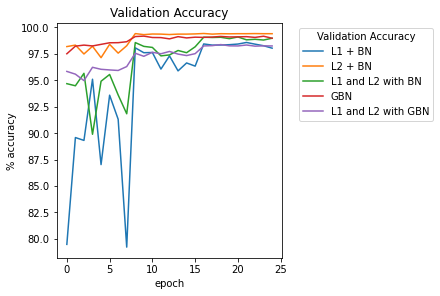

In [21]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
fig, axs = plt.subplots(1, 1, constrained_layout=True)
axs.set_title('Validation Accuracy')
axs.set_xlabel('epoch')
axs.set_ylabel('% accuracy')

p1, = plt.plot(testAccuracy_plot[0], label='L1 + BN')
p2, = plt.plot(testAccuracy_plot[1], label='L2 + BN')
p3, = plt.plot(testAccuracy_plot[2], label='L1 and L2 with BN')
p4, = plt.plot(testAccuracy_plot[3], label='GBN')
p5, = plt.plot(testAccuracy_plot[4], label='L1 and L2 with GBN')

plt.legend(handles=[p1, p2, p3, p4, p5], title='Validation Accuracy', bbox_to_anchor=(1.05, 1), loc='upper left')

## Plot: Test Loss:

Test Loss for 5 models

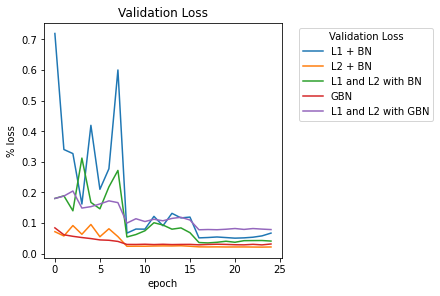

In [23]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
fig, axs = plt.subplots(1, 1, constrained_layout=True)
axs.set_title('Validation Loss')
axs.set_xlabel('epoch')
axs.set_ylabel('% loss')

p1, = plt.plot(testLoss_plot[0], label='L1 + BN')
p2, = plt.plot(testLoss_plot[1], label='L2 + BN')
p3, = plt.plot(testLoss_plot[2], label='L1 and L2 with BN')
p4, = plt.plot(testLoss_plot[3], label='GBN')
p5, = plt.plot(testLoss_plot[4], label='L1 and L2 with GBN')

plt.legend(handles=[p1, p2, p3, p4, p5], title='Validation Loss', bbox_to_anchor=(1.05, 1), loc='upper left')

## Plot: Mis Classified images

25 mis-classified images with Prediction and Target

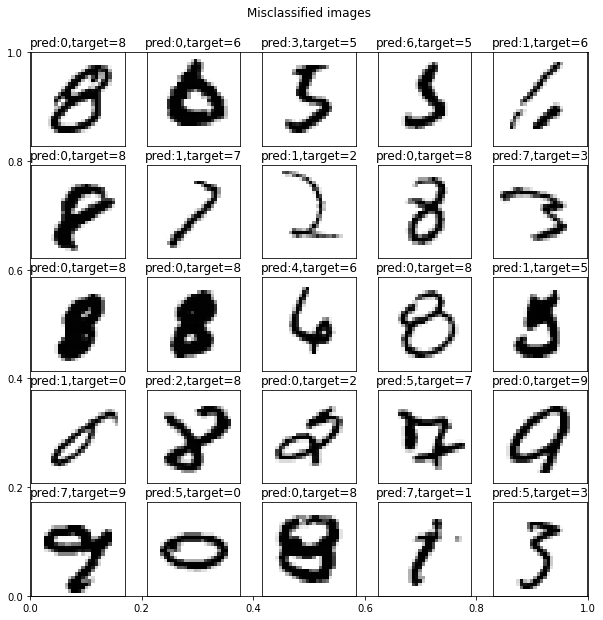

In [28]:
fig = plt.figure(figsize=(10,10))
plt.title("Misclassified images\n\n")

for index in range(25):
    ax = fig.add_subplot(5, 5, index +1, xticks=[], yticks=[])
    image = misclassifiedImages[index]   
    pred = misclassifiedPredictions[index].cpu().numpy()
    target = misclassifiedTargets[index].cpu().numpy()
    ax.imshow(image.cpu().numpy().squeeze(), cmap='gray_r')    
    ax.set_title(f'pred:{pred},target={target}')